# Sales forecast of autoglass by month

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_excel('sales_forecast.xlsx')

### Understanding the dataset

In [3]:
df.head()

,Филиал,Клиент,Код,Тип товара,Тип стекла,День,Месяц,Год,Продажи,Сумма Грн,Дата,Город,Область,Год-Месяц,Unnamed: 14
0,1,1,0001T0-0,1,0,15,6,2021,1.0,102.0,2021-06-15,1,1,2021-6,NaN
1,1,2,0001T0-0,1,0,22,9,2022,3.0,402.0,2022-09-22,2,2,2022-9,NaN
2,1,3,0002T0-0,1,0,5,10,2022,1.0,467.0,2022-10-05,1,1,2022-10,NaN
3,1,3,0002T0-0,1,0,31,10,2022,2.0,920.0,2022-10-31,1,1,2022-10,NaN
4,1,4,0003T0-0,1,0,25,2,2021,1.0,262.0,2021-02-25,1,1,2021-2,NaN


In [4]:
df.shape

(138288, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138288 entries, 0 to 138287
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Филиал       138288 non-null  int64         
 1   Клиент       138288 non-null  int64         
 2   Код          138288 non-null  object        
 3   Тип товара   138288 non-null  int64         
 4   Тип стекла   138288 non-null  int64         
 5   День         138288 non-null  int64         
 6   Месяц        138288 non-null  int64         
 7   Год          138288 non-null  int64         
 8   Продажи      138288 non-null  float64       
 9   Сумма Грн    138288 non-null  float64       
 10  Дата         138288 non-null  datetime64[ns]
 11  Город        138288 non-null  int64         
 12  Область      138288 non-null  int64         
 13  Год-Месяц    138288 non-null  object        
 14  Unnamed: 14  1 non-null       float64       
dtypes: datetime64[ns](1), float64(3), 

In [6]:
df = df.rename(columns = {'Филиал':'branch', 'Клиент':'customer', 'Код':'item', \
                          'Тип товара': 'type_of_item', 'Тип стекла':'glass_type', \
                         'День':'day', 'Месяц': 'month', 'Год': 'year', 'Продажи': 'sales', \
                          'Сумма Грн' : 'cost', 'Дата': 'date', 'Год-Месяц' : 'year_month'})

### Data preprocessing

In [7]:
df['new_item'] = pd.Series(df['item'].values.flatten()).str.split('-').str[0]

In [8]:
df['item_class'] = df['new_item'].str[:5]

In [9]:
df = df.loc[:, ['branch','customer', 'date', 'new_item', 'item_class', 'type_of_item', 'sales', 'cost']]

In [10]:
df['new_item'] = (pd.factorize(df['new_item'])[0] + 1).tolist()
df['item_class'] = (pd.factorize(df['item_class'])[0] + 1).tolist()

In [11]:
df.dtypes

branch                   int64
customer                 int64
date            datetime64[ns]
new_item                 int64
item_class               int64
type_of_item             int64
sales                  float64
cost                   float64
dtype: object

In [12]:
df['new_date'] = pd.to_datetime(df['date']).dt.strftime("%Y%m%d").astype(int)
df['month'] = pd.to_datetime(pd.to_datetime(df['date']).dt.strftime('%Y-%m'))

In [13]:
df = df.groupby(['month', 'branch','customer', 'new_item', 'item_class', 'type_of_item'], as_index=False). \
                                agg({'sales':'sum', 'cost': 'sum', 'new_date' : 'max'}). \
                                reset_index()

In [14]:
df_feature = pd.DataFrame(df['type_of_item'])
df_feature.reset_index(drop=True, inplace=True)
df_other = df.loc[:, ['month', 'branch', 'customer', 'new_item', 'item_class', 'sales', 'cost', 'new_date']]

In [15]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_feature)
enc_feature_names = enc.get_feature_names_out(input_features=df_feature.columns)

In [16]:
enc_df = pd.DataFrame(enc.transform(df_feature).toarray(), columns=enc_feature_names)

In [17]:
df_f = pd.concat([df_other, enc_df], axis=1)
df.columns

Index(['index', 'month', 'branch', 'customer', 'new_item', 'item_class',
       'type_of_item', 'sales', 'cost', 'new_date'],
      dtype='object')

### Building a regression model

In [18]:
# spliting dataset
X_labels = ['branch', 'customer', 'new_item', 'item_class', 'cost', 'type_of_item']
y_labels = ['sales']
test_df = df[df['new_date'] > int('20211231')]
test_df = test_df.reset_index(drop=True)
train_df = df[df['new_date'] <= int('20211231')]
X_train, y_train = train_df[X_labels], train_df[y_labels]
X_test, y_test = test_df[X_labels], test_df[y_labels]

SEED = 42

In [19]:
X_train.shape, X_test.shape

((76702, 6), (43631, 6))

In [20]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

<AxesSubplot:ylabel='Count'>

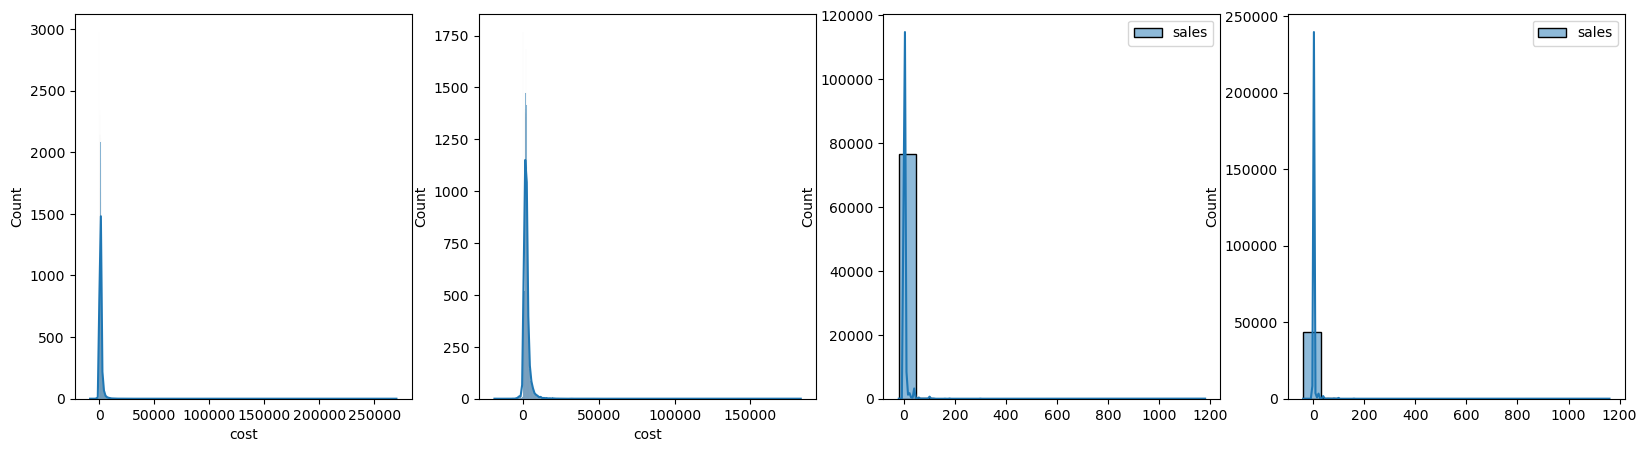

In [21]:
#check distribution
fig, ax = plt.subplots(1, 4, figsize=(20,5))
sns.histplot(data=X_train, x='cost', ax=ax[0], kde=True)
sns.histplot(data=X_test, x='cost', ax=ax[1], kde=True)
sns.histplot(y_train, ax=ax[2], kde=True)
sns.histplot(data=y_test, ax=ax[3], kde=True)

### Model evaluation

In [22]:
def train_model(model, X_train, y_train, cv=5):
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=('r2', 'neg_root_mean_squared_error'),)
    print('Model:', model)
    r2_scores = cv_res['test_r2']
    print('r2 cv scores:', r2_scores)
    print('r2 cv scores mean / stdev:', np.mean(r2_scores), '/', np.std(r2_scores))
    
    rmse_scores = cv_res['test_neg_root_mean_squared_error']
    rmse_scores = [-1*score for score in rmse_scores]
    print('rmse cv scores:', rmse_scores)
    print('rmse cv scores mean / stdev:', np.mean(rmse_scores), '/', np.std(rmse_scores))
    print()

In [23]:
#check the best model

In [24]:
rf = RandomForestRegressor(random_state=SEED)
train_model(model=rf, X_train=X_train_sc, y_train=y_train.values.ravel())

gb = GradientBoostingRegressor(random_state=SEED)
train_model(model=gb, X_train=X_train_sc, y_train=y_train.values.ravel())

hgb = HistGradientBoostingRegressor(random_state=SEED)
train_model(model=hgb, X_train=X_train_sc, y_train=y_train.values.ravel())

Model: RandomForestRegressor(random_state=42)
r2 cv scores: [0.91919966 0.97272692 0.92689097 0.61399765 0.87276603]
r2 cv scores mean / stdev: 0.8611162484031374 / 0.12756195101872797
rmse cv scores: [4.140935048517269, 1.5747610080060477, 1.6373954353023255, 4.587660828098934, 3.6554072202716816]
rmse cv scores mean / stdev: 3.119231908039252 / 1.2703443988903658

Model: GradientBoostingRegressor(random_state=42)
r2 cv scores: [0.96868324 0.9791763  0.88807035 0.88273619 0.92035862]
r2 cv scores mean / stdev: 0.9278049399391216 / 0.039938778381584626
rmse cv scores: [2.577984173041028, 1.3760254523996553, 2.0260056592091273, 2.5285894748254956, 2.892035550332059]
rmse cv scores mean / stdev: 2.280128061961473 / 0.5304454420788127

Model: HistGradientBoostingRegressor(random_state=42)
r2 cv scores: [0.57370626 0.70495353 0.8182259  0.80438111 0.79782771]
r2 cv scores mean / stdev: 0.7398189023878357 / 0.09218455463834688
rmse cv scores: [9.511440685197803, 5.179558916223745, 2.5818682

In [25]:
xgb = XGBRegressor(random_state=SEED)
train_model(model=xgb, X_train=X_train_sc, y_train=y_train.values.ravel())

lgb = LGBMRegressor(random_state=SEED)
train_model(model=lgb, X_train=X_train_sc, y_train=y_train.values.ravel())

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
r2 cv scores: [ 0.82502805  0.98800765  0.90527537 -0.54236288  0.545203  ]
r2 cv scores mean / stdev: 0.5442302393901086 / 0.5633515654769856
rmse cv scores: [6.09362951101574, 1.0442384293304505, 1.863800976574279, 9.170428138000995, 6.911033923840572]

In [26]:
#best model
#Model: GradientBoostingRegressor(random_state=42)
#r2 cv scores: [0.96868324 0.9791763  0.88807035 0.88273619 0.92035862]
#r2 cv scores mean / stdev: 0.9278049399391216 / 0.039938778381584626
#rmse cv scores: [2.577984173041028, 1.3760254523996553, 2.0260056592091273, 2.5285894748254956, 2.892035550332059]
#rmse cv scores mean / stdev: 2.280128061961473 / 0.5304454420788127

#best model when used encoder OHE
#Model: RandomForestRegressor(random_state=42)
#r2 cv scores: [0.91974738 0.97113367 0.94290069 0.81013308 0.91397875]
#r2 cv scores mean / stdev: 0.9115787151874335 / 0.05457391781248163
#rmse cv scores: [4.126876176431207, 1.6201057860207124, 1.4470498304420165, 3.2175179684602235, 3.005640949858683]
#rmse cv scores mean / stdev: 2.6834381422425686 / 1.0131042420102772

Feature: 0, Score: 0.00004
Feature: 1, Score: 0.00004
Feature: 2, Score: 0.02132
Feature: 3, Score: 0.00332
Feature: 4, Score: 0.44928
Feature: 5, Score: 0.52599


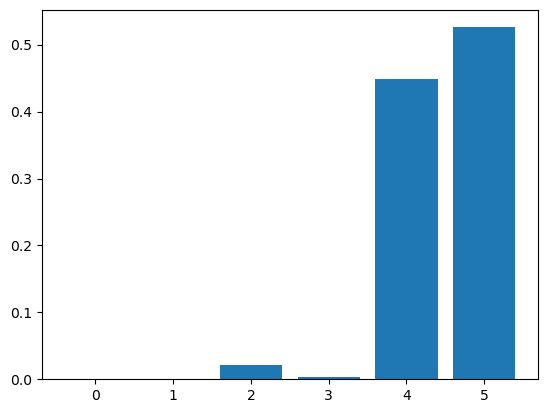

In [27]:
gb = GradientBoostingRegressor(random_state=SEED)
gb.fit(X_train_sc, y_train.values.ravel())
importance = gb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Model prediction

In [28]:
y_pred = gb.predict(X_test_sc)
y_pred = y_pred.reshape(-1,1)
gb.score(X_test_sc, y_test)

0.7336983969178483

In [29]:
lst = []
for i in range(len(y_pred)):
    lst.append(y_pred[i][0])
y_pred_series = pd.Series(lst, name='prediction')

In [30]:
test_df = test_df.merge(y_pred_series, left_index=True, right_index=True)

In [31]:
#monthly sales plot of prediction
df_m = df.groupby('month').agg({'sales': 'sum'})
test_df_m = test_df.groupby('month').agg({'prediction': 'sum'})

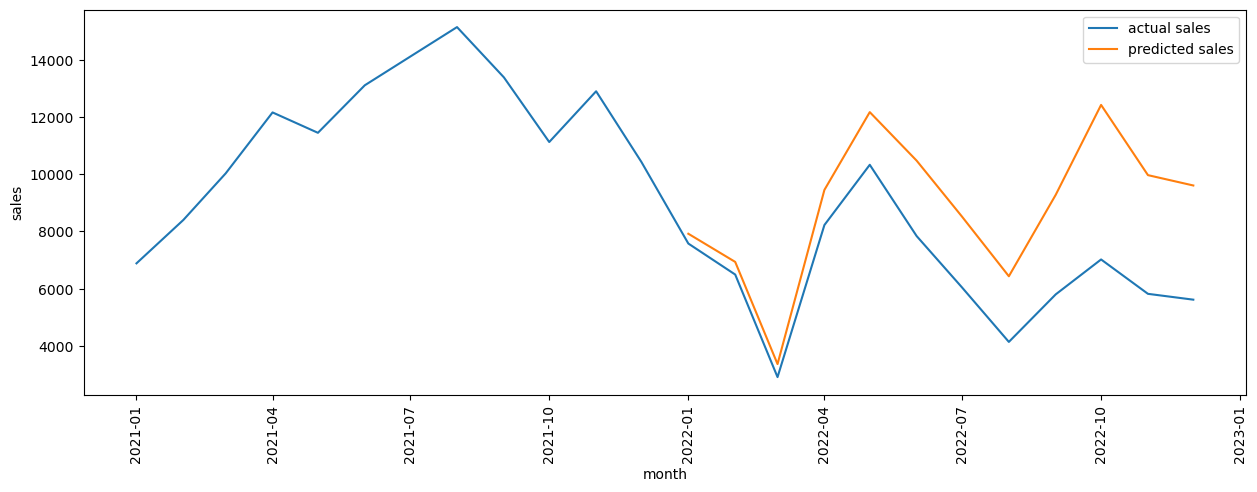

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df_m, x='month', y='sales' , label='actual sales')
sns.lineplot(data=test_df_m, x='month', y='prediction', label='predicted sales')
ax.tick_params(axis='x', rotation=90)